In [129]:
import nbformat

# Read your notebook (assuming version 4 for example purposes)
nb = nbformat.read("ml_project.ipynb", as_version=4)

# Normalize the notebook to add missing id fields and other updates
nbformat.validator.validate(nb)

# Write the normalized notebook back to a file
nbformat.write(nb, "ml_project_normalized.ipynb")

In [130]:
%run ml_project_normalized.ipynb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
dropped columns


/tmp/ipykernel_898769/1199118304.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_series = pd.to_datetime(df['intake_time'], errors='coerce')


cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
Done running ml_project.ipynb.


In [131]:
#kog_reg
nb = nbformat.read("log_reg.ipynb", as_version=4)
nbformat.validator.validate(nb)
nbformat.write(nb, "log_reg_normalized.ipynb")

# Random Frest
nb = nbformat.read("random_forest.ipynb", as_version=4)
nbformat.validator.validate(nb)
nbformat.write(nb, "random_forest_normalized.ipynb")

# X Random Trees
nb = nbformat.read("x_random_trees.ipynb", as_version=4)
nbformat.validator.validate(nb)
nbformat.write(nb, "x_random_trees_normalized.ipynb")

In [132]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline  # Important for SMOTE compatibility
from imblearn.over_sampling import SMOTENC

In [133]:
# rerun when i make changes
#%run log_reg.ipynb
#%run random_forest.ipynb
#%run x_random_trees.ipynb
df_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,intake_month,intake_hour,primary_color,is_mix,size,outcome_type
0,Stray,Normal / Behavior,Dog,Spayed Female,96.0,2,2015,7,12,white,0,3,Return to Owner
1,Stray,Normal / Behavior,Dog,Intact Male,11.0,7,2016,4,18,sable,1,2,Return to Owner
2,Public Assist,Normal / Behavior,Cat,Neutered Male,24.0,Common,2022,5,0,orange,0,2,Transfer
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,24.0,2,2017,2,12,chocolate,1,4,Return to Owner
4,Public Assist,Normal / Behavior,Dog,Neutered Male,72.0,3,2019,4,9,black,1,5,Return to Owner


In [134]:
def train_voting_classifier(X_train, y_train, X_test, models, voting='soft'):
    """
    Trains a VotingClassifier with the given models and evaluates it on the test data.
    
    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Test features
    - models: List of tuples (model_name, model_instance)
    - voting: 'hard' or 'soft' for the type of voting to be used (default is 'soft')
    
    Returns:
    - trained_model: Trained VotingClassifier
    - test_predictions: Predictions on the test set
    """
    # Initialize the VotingClassifier with the given models
    voting_clf = VotingClassifier(estimators=models, voting=voting, n_jobs=-1)
    
    # Fit the model
    voting_clf.fit(X_train, y_train)
    
    # Make predictions
    test_predictions = voting_clf.predict(X_test)
    
    # Evaluate the model
    accuracy = balanced_accuracy_score(y_train, voting_clf.predict(X_train))
    print(f"Training Accuracy: {accuracy:.4f}")
    
    return voting_clf, test_predictions

# needs CV loop after testing

In [ ]:
df_train = bucket_seasons(df_train)
df_test = bucket_seasons(df_test)

df_train = bucket_days(df_train)
df_test = bucket_days(df_test)

df_train = df_train.drop(columns=['size', 'intake_hour', 'intake_month'])
df_test = df_test.drop(columns=['size', 'intake_hour', 'intake_month'])

df_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,primary_color,is_mix,outcome_type,season,time_of_day
0,Stray,Normal / Behavior,Dog,Spayed Female,96.0,2,2015,white,0,Return to Owner,Summer,Afternoon
1,Stray,Normal / Behavior,Dog,Intact Male,11.0,7,2016,sable,1,Return to Owner,Spring,Evening
2,Public Assist,Normal / Behavior,Cat,Neutered Male,24.0,Common,2022,orange,0,Transfer,Spring,Night
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,24.0,2,2017,chocolate,1,Return to Owner,Winter,Afternoon
4,Public Assist,Normal / Behavior,Dog,Neutered Male,72.0,3,2019,black,1,Return to Owner,Spring,Morning


In [137]:
X = df_train.drop(columns=['outcome_type'])
y = df_train['outcome_type']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)




In [ ]:
# random forest
import pandas as pd 
from sklearn.preprocessing import LabelEncoder

# EXTRA DATA CLEANING
rf_X_train = X_train.drop(columns=['is_mix'])
rf_X_test = X_test.drop(columns=['is_mix'])

# label coder will only be used for the outcome labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Define rare classes that need oversampling 
rare_classes = [
  label for label, count in pd.Series(y_train).value_counts().items()
  if count < 0.05 * len(y_train)
]
print("Rare classes:")
for cls in rare_classes:
  print(f"  {cls}: {le.classes_[cls]}")

# Define categorical features - either column names or column indices
cat_cols_onehot = ['intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'season'] # TODO: should i add intake month, hour, and year here?
cat_cols_freq   = ['breed', 'primary_color']

# Frequency encode selected high-cardinality features
for col in cat_cols_freq:
  # Fit on train, apply same mapping to test
  freq_map = rf_X_train[col].value_counts()
  rf_X_train[col] = rf_X_train[col].map(freq_map)
  # Unseen categories in test get frequency 0
  rf_X_test[col]  = rf_X_test[col].map(freq_map).fillna(0)

# One-hot encode remaining categorical features
rf_X_train = pd.get_dummies(rf_X_train, columns=cat_cols_onehot, drop_first=True)
rf_X_test  = pd.get_dummies(rf_X_test,  columns=cat_cols_onehot, drop_first=True)
# Align columns: add missing columns in X_test, fill with 0s
rf_X_test = rf_X_test.reindex(columns=rf_X_train.columns, fill_value=0)

print(X_train.head())
print(rf_X_train.head())

In [138]:
X_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,primary_color,is_mix,season,time_of_day
107615,Stray,Normal / Behavior,Cat,Intact Female,1.0,Common,2021,torbie,0,Summer,Morning
13002,Stray,Injured,Dog,Intact Male,24.0,3,2014,brown brindle,1,Summer,Morning
32513,Public Assist,Normal / Behavior,Dog,Intact Female,12.0,4,2019,brown,1,Summer,Night
79497,Stray,Normal / Behavior,Cat,Intact Female,1.0,Common,2015,calico,1,Summer,Evening
88489,Stray,Normal / Behavior,Dog,Intact Female,4.0,2,2017,black,0,Spring,Morning


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END logreg__C=0.3845401188473625, logreg__class_weight={0: 0.4040806125462931, 1: 21.29916167664671, 2: 6.4625, 3: 1.3310979717087044, 4: 0.6360118728319565}, logreg__fit_intercept=True, logreg__max_iter=8000, logreg__penalty=l2, logreg__solver=saga;, score=0.460 total time=  48.7s
[CV 2/5] END logreg__C=0.3845401188473625, logreg__class_weight={0: 0.4040806125462931, 1: 21.29916167664671, 2: 6.4625, 3: 1.3310979717087044, 4: 0.6360118728319565}, logreg__fit_intercept=True, logreg__max_iter=8000, logreg__penalty=l2, logreg__solver=saga;, score=0.453 total time=   0.9s
[CV 3/5] END logreg__C=0.3845401188473625, logreg__class_weight={0: 0.4040806125462931, 1: 21.29916167664671, 2: 6.4625, 3: 1.3310979717087044, 4: 0.6360118728319565}, logreg__fit_intercept=True, logreg__max_iter=8000, logreg__penalty=l2, logreg__solver=saga;, score=0.458 total time=   2.7s
[CV 4/5] END logreg__C=0.3845401188473625, logreg__class_weight

/u/nneoma/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=0.5347746602583892, logreg__class_weight={0: 0.4040806125462931, 1: 21.29916167664671, 2: 6.4625, 3: 1.3310979717087044, 4: 0.6360118728319565}, logreg__fit_intercept=False, logreg__max_iter=8000, logreg__penalty=l2, logreg__solver=saga;, score=0.459 total time= 2.1min
[CV 2/5] END logreg__C=0.5347746602583892, logreg__class_weight={0: 0.4040806125462931, 1: 21.29916167664671, 2: 6.4625, 3: 1.3310979717087044, 4: 0.6360118728319565}, logreg__fit_intercept=False, logreg__max_iter=8000, logreg__penalty=l2, logreg__solver=saga;, score=0.453 total time=   1.1s
[CV 3/5] END logreg__C=0.5347746602583892, logreg__class_weight={0: 0.4040806125462931, 1: 21.29916167664671, 2: 6.4625, 3: 1.3310979717087044, 4: 0.6360118728319565}, logreg__fit_intercept=False, logreg__max_iter=8000, logreg__penalty=l2, logreg__solver=saga;, score=0.458 total time=   1.8s
[CV 4/5] END logreg__C=0.5347746602583892, logreg__class_weight={0: 0.4040806125462931, 1: 21.29916167664671, 2: 6.4625, 

/u/nneoma/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/u/nneoma/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total tim

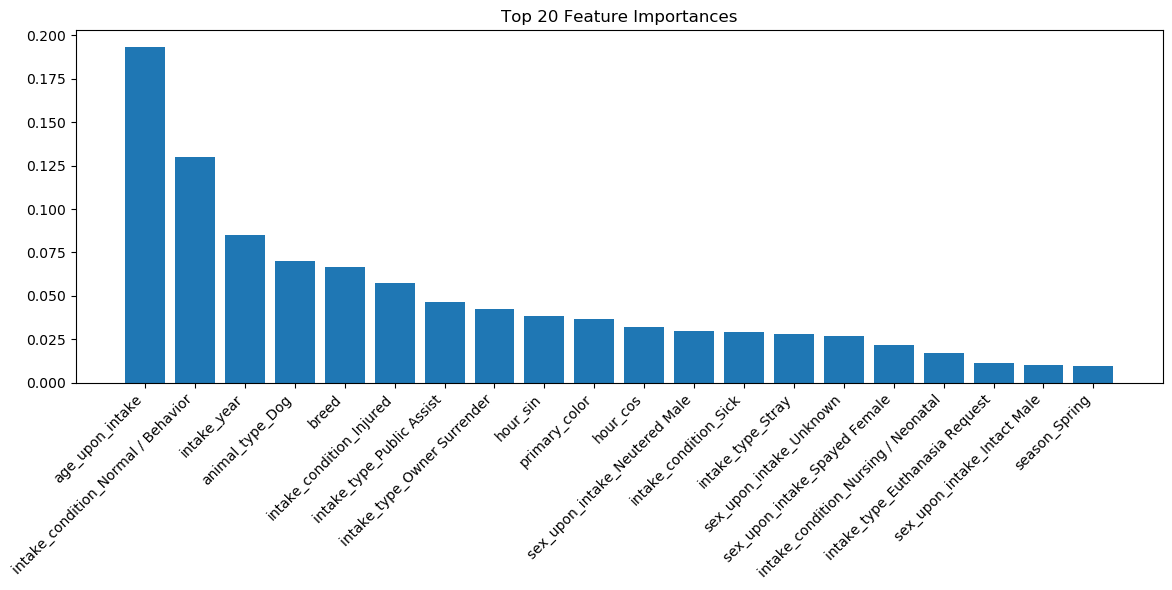

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Best CV accuracy: 0.4995439806453293
[CV] END ................................ score: (test=0.505) total time=   0.6s
[CV] END ................................ score: (test=0.495) total time=   0.6s
[CV] END ................................ score: (test=0.520) total time=   0.6s
[CV] END ................................ score: (test=0.489) total time=   0.5s
[CV] END ................................ score: (test=0.489) total time=   0.5s
Generalization accuracy (via cross_val_score): 0.4995439806453293
Class weights: {0: 0.4040806125462931, 1: 21.29916167664671, 2: 6.4625, 3: 1.3310979717087044, 4: 0.6360118728319565}

[INFO] Starting training with 88924 samples
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n

/u/nneoma/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/u/nneoma/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/u/nneoma/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


ValueError: could not convert string to float: 'Stray'

In [ ]:
cat_cols = ['intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed','season', 'is_mix', 'time_of_day'] # experimenting with droping color
num_cols = ['age_upon_intake', 'intake_year']    # Replace with your actual numerical columns
freq_cols ['primary_color'] # for trees

# Example usage:
models = [
    ('logreg', train_logreg_classifier(X_train, y_train, X_test, cat_cols, num_cols)[0]), #logistic regression
    ('rf', train_RF_classifier(X_train, y_train, X_test, cat_cols)[0]), #random forest
    ('xrt', train_XRT_classifier(rf_X_train, y_train, rf_X_test, rare_classes)[0]) #x random trees
]

# Assuming X_train, y_train, X_test are already defined in your environment
voting_model, test_predictions = train_voting_classifier(X_train, y_train, X_test, models, voting='soft')

classification_report_with_accuracy_score(y_test, test_predictions)

In [ ]:
# assuming these are pipelines or models you've already trained/tuned
'''
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),      # best XGBoost model
        ('cat', catboost_model), # best CatBoost model
        ('logreg', log_reg_model),
        ('rf', rf_model),
        ('nb', nb_model)
    ],
    voting='soft',
  #  weights=[3, 2.5, 2, 1.5, 1],  # optional: weight more accurate models
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# Evaluate
from sklearn.metrics import balanced_accuracy_score
print("Ensemble Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
'''
